In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/amcs1729/Predicting-cloud-CPU-usage-on-Azure-data.git

Cloning into 'Predicting-cloud-CPU-usage-on-Azure-data'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 52 (delta 17), reused 30 (delta 4), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [ ]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



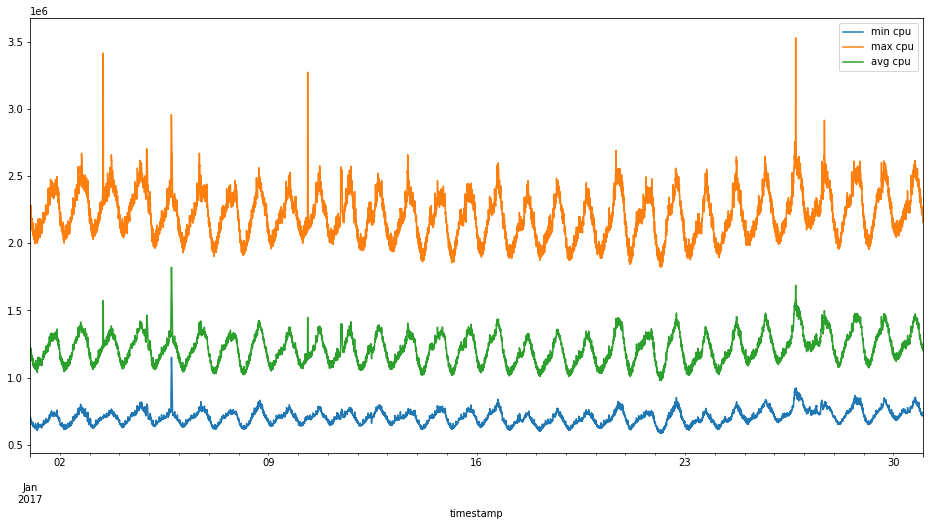

In [ ]:
df = pd.read_csv('/content/Predicting-cloud-CPU-usage-on-Azure-data/azure.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [ ]:
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [ ]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [ ]:
TIME_STEPS = 400
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [ ]:
#-----------------------------------------------------------
# USING A INDEPENDENT RNN MODEL FOR PREDICTION ON TIME SERIES
# DEFINING 'RECURRENT_MAX' ACCORDING TO PAPER
#-----------------------------------------------------------
RECURRENT_MAX = pow(2, 1 / TIME_STEPS)
model = tf.keras.models.Sequential()
model.add(IndRNN(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(IndRNN(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

NameError: ignored

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0000001,)
callbacks = [es , lr_red]
#adamOpt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_split=0.25, 
                    batch_size=512, 
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/200


InvalidArgumentError: ignored

In [ ]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

ValueError: ignored

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

In [ ]:
from __future__ import absolute_import
import warnings

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import RNN

def _generate_dropout_mask(ones, rate, training=None, count=1):
    def dropped_inputs():
        return K.dropout(ones, rate)
    if count > 1:
        return [K.in_train_phase(
            dropped_inputs,
            ones,
            training=training) for _ in range(count)]
    return K.in_train_phase(
        dropped_inputs,
        ones,
        training=training)

class IndRNNCell(Layer):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        recurrent_clip_max: Can be one of None or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix, used for the linear transformation of the
            recurrent state.
            Can be `None` or an available initializer. Defaults to `None`.
            If None, defaults to uniform initialization.
            If None, and recurrent_clip_min/max is not None, then
            it uses those clip values as for uniform initialization.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, must be 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """
     def __init__(self, units,
                 recurrent_clip_min=-2,
                 recurrent_clip_max=2,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(IndRNNCell, self).__init__(**kwargs)

        if implementation != 2:
            warnings.warn(
                "IndRNN only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        if recurrent_clip_min is None or recurrent_clip_max is None:
            recurrent_clip_min = None
            recurrent_clip_max = None

            self.units = units
        self.recurrent_clip_min = recurrent_clip_min
        self.recurrent_clip_max = recurrent_clip_max
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer) \
                                     if recurrent_initializer is not None else None
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = (self.units,)
        self._dropout_mask = None
        self._recurrent_masks = None

        def build(self, input_shape):
        input_dim = input_shape[-1]

        if self.recurrent_clip_min == -1 or self.recurrent_clip_max == -1:
            self.recurrent_clip_min = 0.0

            if hasattr(self, 'timesteps') and self.timesteps is not None:
                self.recurrent_clip_max = pow(2.0, 1. / int(self.timesteps))
            else:
                warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"
                              "Defaulting to max clipping range of 1.0. \n"
                              "If this model was trained using a specific timestep during training, "
                              "inference may be wrong due to this default setting.\n"
                              "Please ensure that you use the same number of timesteps during training "
                              "and evaluation")
                self.recurrent_clip_max = 1.0

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      name='input_kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        
        if self.recurrent_initializer is None:
            if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
                initialization_value = min(self.recurrent_clip_max, 1.0)
                self.recurrent_initializer = initializers.RandomUniform(-initialization_value,
                                                                  initialization_value)
            else:
                self.recurrent_initializer = initializers.RandomUniform(-1.0, 1.0)

        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                                name='recurrent_kernel',
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)

        if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
            if abs(self.recurrent_clip_min):
                abs_recurrent_kernel = K.abs(self.recurrent_kernel)
                min_recurrent_kernel = K.maximum(abs_recurrent_kernel, abs(self.recurrent_clip_min))
                self.recurrent_kernel = K.sign(self.recurrent_kernel) * min_recurrent_kernel

self.recurrent_kernel = K.clip(self.recurrent_kernel,
                                           self.recurrent_clip_min,
                                           self.recurrent_clip_max)

        if self.use_bias:
            bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_masks is None):
            _recurrent_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=1)
            self._recurrent_masks = _recurrent_mask

            # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._recurrent_masks

        h_tm1 = states[0]  # previous state

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        if 0. < self.recurrent_dropout < 1.:
            h_tm1 *= rec_dp_masks[0]

        h = K.dot(inputs, self.kernel)
        h = h + (h_tm1 * self.recurrent_kernel)

        if self.use_bias:
            h = K.bias_add(h, self.bias)

        h = self.activation(h)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, [h]

        def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class IndRNN(RNN):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        recurrent_clip_max: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
            unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
        Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output.
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
            # References
        - [Learning to forget: Continual prediction with NestedLSTM](http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks](http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](http://arxiv.org/abs/1512.05287)
        - [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    """
def __init__(self, units,
                 recurrent_clip_min=-1,
                 recurrent_clip_max=-1,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
  if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = IndRNNCell(units,
                          recurrent_clip_min=recurrent_clip_min,
                          recurrent_clip_max=recurrent_clip_max,
                          activation=activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          implementation=implementation)
        super(IndRNN, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     unroll=unroll,
                                     **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def build(self, input_shape):
        timesteps = input_shape[1]

        if timesteps is None:
            warnings.warn("Number of timesteps was not provided. If this model is being used for training purposes, \n"
                          "it is recommended to provide a finite number of timesteps when defining the input shape, \n"
                          "so as to initialize the weights of the recurrent kernel properly and avoid exploding gradients.")

        self.cell.timesteps = timesteps

        super(IndRNN, self).build(input_shape)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_masks = None
        return super(IndRNN, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state,
                                        constants=constants)
        @property
    def units(self):
        return self.cell.units

    @property
    def recurrent_clip_min(self):
        return self.cell.recurrent_clip_min

    @property
    def recurrent_clip_max(self):
        return self.cell.recurrent_clip_max

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):

      return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

        @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)